In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress


from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

In [3]:
# load in the data from all tissues
overlap = load_across_tissues(config, load_overlap)
overlap['num_vars'] = overlap['variant_list'].apply(ast.literal_eval).apply(len)


In [4]:
# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
qtls_grouped = overlap.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_full_id':list, 
                                                                                'orig_cs_dataset':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'lead_variant_pos':'first', 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
qtls_grouped['num_e_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_e_')/2
qtls_grouped['num_pc_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


In [5]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes = qtls_grouped[qtls_grouped['exclusive_label']=='shared'].explode(['orig_cs_dataset', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'orig_cs_dataset']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'orig_cs_dataset']).agg({'num_vars':min, 'cluster_size':'first'})
cs_sizes_pivot = cs_sizes.pivot_table(index=['lead_variant_id', 'cluster_size'], 
                           columns='orig_cs_dataset', 
                           values='num_vars', 
                           fill_value=0).reset_index()

In [9]:
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['control_eqtl'] < cs_sizes_pivot['pc_qtl'], 
    'eqtl_smaller', 
    np.where(
        cs_sizes_pivot['control_eqtl'] > cs_sizes_pivot['pc_qtl'], 
        'pcqtl_smaller', 
        'same'
    )
)
cs_sizes_pivot['small_cs'] = (cs_sizes_pivot['control_eqtl'] < 4 )|(cs_sizes_pivot['pc_qtl'] < 4)

In [ ]:
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

In [10]:
cs_sizes_pivot['cluster_size_clip'] = cs_sizes_pivot['cluster_size'].clip(0,5)

<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

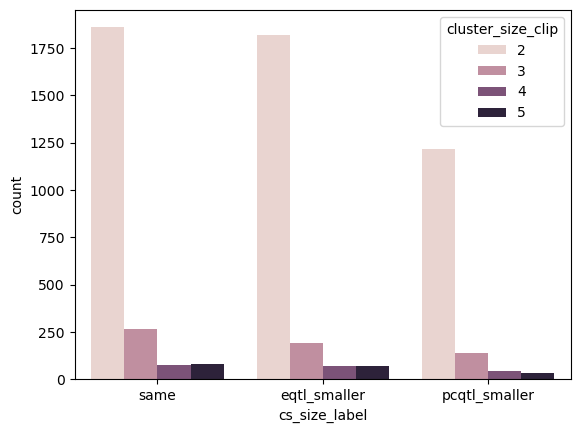

In [11]:
sns.countplot(cs_sizes_pivot, x='cs_size_label', hue='cluster_size_clip')

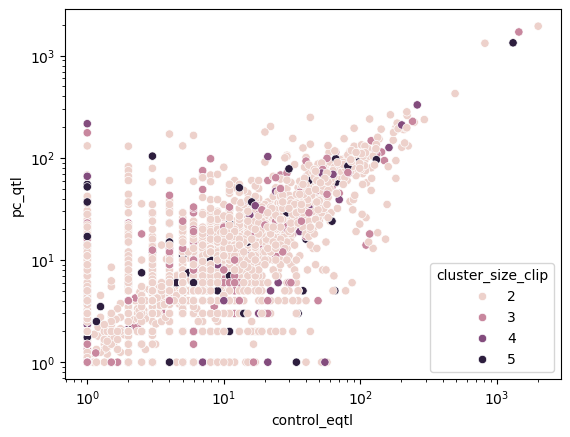

In [12]:
ax = sns.scatterplot(cs_sizes_pivot, x='control_eqtl', y='pc_qtl', hue='cluster_size_clip')
ax.set_xscale('log')
ax.set_yscale('log')